In [1]:

# import libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [2]:
bucket_name = 'awsgis' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 error:  An error occurred (IllegalLocationConstraintException) when calling the CreateBucket operation: The unspecified location constraint is incompatible for the region specific endpoint this request was sent to.


In [3]:
import os
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')
NUM_SAMPLES = 5

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [4]:
def load_data(_input_dir, _output_dir="output", _data_size=-1):
    """
    :param _input_dir: input directory name
                      AWS S3 directory name, where the input files are stored
    :param _output_dir: output directory name
                      AWS S3 directory name, where the output files are saved
    :param _data_size: size of data
                      Data size, that needs to be tested, by default it takes value of
                      -1, which means consider all the data
    :return:
            the processed data, and demand data
    """
    import pandas as pd
    from pandas import DataFrame

    # load all the data
    months = ["apr", "may", "jun", "jul", "aug", "sep"]
    file_format = "uber-processed-data-{}14.csv"
    _data = DataFrame()
    for month in months:
        file_name = _input_dir + "/" + file_format.format(month)
        df_sub = pd.read_csv(file_name)
        _data = _data.append(df_sub)

    # sample the data
    if _data_size > 0:
        _data = _data.sample(n=_data_size)

    # summarizing demand data
    _demand = (_data.groupby(['zip']).count()['Date/Time']).reset_index()
    _demand.columns = ['Zip', 'Number of Trips']
    _demand.to_csv(_output_dir + "/demand.csv", index=False)

    _demand_w = (_data.groupby(['zip', 'weekday']).count()['Date/Time']).reset_index()
    _demand_w.columns = ['Zip', 'Weekday', 'Number of Trips']
    _demand_w.to_csv(_output_dir + "/demand_dow.csv", index=False)

    _demand_h = (_data.groupby(['zip', 'hour']).count()['Date/Time']).reset_index()
    _demand_h.columns = ['Zip', 'Hour', 'Number of Trips']
    _demand_h.to_csv(_output_dir + "/demand_h.csv", index=False)

    _demand_wh = (_data.groupby(['zip', 'weekday', 'hour']).count()['Date/Time']).reset_index()
    _demand_wh.columns = ['Zip', 'Weekday', 'Hour', 'Number of Trips']
    _demand_wh.to_csv(_output_dir + "/demand_h_dow.csv", index=False)

    return _data, _demand, _demand_w, _demand_h, _demand_wh

In [5]:
class DemandPredictorBase(object):
    """
        Base class for demand predictor
    """

    def __init__(self, _x, _y, _prefix, train=True, output_dir="."):
        self.x = _x
        self.y = _y
        self.prefix = _prefix
        self.output_dir = output_dir
        self.model = self.build_model()
        if train:
            self.train()

    def build_model(self):
        raise NotImplementedError

    def train(self):
        raise NotImplementedError

    def predict(self, _x_test):
        """
        :param _x_test: test dataset
        :return: prediction for the given test dataset _x_test
        """
        return self.model.predict(_x_test)

    def predict_and_scale(self, _x_test, _y_scalar):
        """
        :param _x_test: test dataset
        :param _y_scalar: Scaler
        :return: prediction for the given test dataset _x_test, scaled to the scalar
        """
        return _y_scalar.inverse_transform(self.predict(_x_test))

    @staticmethod
    def get_mse(_y_test, _y_pred):
        """
        :param _y_test: actual test values
        :param _y_pred: predicted test values
        :return: return the mean square error
        """
        return mean_squared_error(_y_test, _y_pred)
    
    def save_model(self, _data_size, _model_id):
        if self.model is not None:
            import s3fs
            from pickle import dump
            fs = s3fs.S3FileSystem(anon=False)
            bucket = f"{self.output_dir}"
            file_name = f"{self.prefix}_model_{_data_size}_{_model_id}.pickle"
            dump(self.model, fs.open(f"s3://{bucket}/{file_name}", 'wb'))


class DemandPredictorNN(DemandPredictorBase):
    def __init__(self, _x, _y, train=True, output_dir=".", hidden_layer_conf=None, d_key="", dt_size=-1):
        self.input_shape = len(_x[0])
        self.output_shape = len(_y[0])
        self.hidden_layer_conf = hidden_layer_conf
        self.d_key = d_key
        self.dt_size = dt_size
        self.epochs = 100
        self.batch_size = 150
        self.verbose = 0
        self.validation_split = 0.2
        self.learning_rate = 0.01
        self.history = None
        super(DemandPredictorNN, self).__init__(_x, _y, "nn", train, output_dir)

    def build_model(self):
        """
            build the model
        """

        model = Sequential()
        model.add(InputLayer(input_shape=(self.input_shape,)))
        if self.hidden_layer_conf is None:
            model.add(Dense(168, activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(24, activation='relu'))
            model.add(Dropout(0.01))
            model.add(Dense(self.output_shape, activation='linear'))
            model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        else:
            for layer in self.hidden_layer_conf:
                model.add(Dense(layer["neurons"], activation=layer["activation"]))
        model.add(Dense(self.output_shape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def predict(self, _x_test):
        if os.path.exists(self.output_dir + f"/best_model_{self.d_key}_{self.dt_size}.h5"):
            self.model = load_model(self.output_dir + f"/best_model_{self.d_key}_{self.dt_size}.h5")
        return super(DemandPredictorNN, self).predict(_x_test)

    def train(self):
        """
            train the model
        """
        self.history = \
            self.model.fit(
                self.x, self.y,
                epochs=self.epochs, batch_size=self.batch_size,
                verbose=self.verbose, validation_split=self.validation_split,
                use_multiprocessing=True
            )

    def save_model(self, _data_size, _model_id):
        if self.model is not None:
            import io
            import s3fs
            model_data = io.BytesIO()
            self.model.save(model_data)
            model_data.seek(0)
            s3 = s3fs.S3FileSystem(anon=False)  # Uses default credentials
            bucket = f"{self.output_dir}"
            file_name = f"{self.prefix}_model_{_data_size}_{_model_id}.h5"
            with s3.open(f's3://{bucket}/{file_name}', 'wb') as f:
                f.write(model_data.getbuffer())  

    def plot(self, _i, _mse=None):
        losses = self.history.history['loss']
        val_losses = self.history.history['val_loss']
        epochs = [i for i in range(len(losses))]
        plt.xscale('log')
        plt.xlabel("Epochs [Log Scale]")
        plt.ylabel("Loss")
        legend = ["Val Loss", "Train Loss"]
        if _mse is not None:
            plt.plot(epochs, [_mse for _ in range(len(epochs))])
            legend = ["MSE"] + legend
        plt.plot(epochs, val_losses)
        plt.plot(epochs, losses)
        plt.legend(legend, loc="lower center", bbox_to_anchor=(0.5, 0.0))
        plt.title("Variation of Loss function over time")
        import io
        import s3fs
        img_data = io.BytesIO()
        plt.savefig(img_data, format='pdf', bbox_inches='tight')
        img_data.seek(0)
        s3 = s3fs.S3FileSystem(anon=False)  # Uses default credentials
        with s3.open(f'{_i}.pdf', 'wb') as f:
            f.write(img_data.getbuffer())
        plt.close()


class DemandPredictorSVR(DemandPredictorBase):
    def __init__(self, _x, _y, train=True, output_dir="."):
        self.kernel = 'rbf'
        self.gamma = 10
        self.c = 10
        super(DemandPredictorSVR, self).__init__(_x, _y, "svr", train, output_dir)

    def build_model(self):
        """
            build the model
        """
        model = SVR(kernel=self.kernel, gamma=self.gamma, C=self.c)
        return model

    def train(self):
        """
            train the model
        """
        self.model.fit(self.x, self.y)

from sklearn.naive_bayes import GaussianNB
class DemandPredictorNB(DemandPredictorBase):
    def __init__(self, _x, _y, train=True, output_dir="."):

        super(DemandPredictorNB, self).__init__(_x, _y, "nb", train, output_dir)

    def build_model(self):
        """
            build the model
        """
        model = GaussianNB()
        return model

    def train(self):
        """
            train the model
        """
        self.model.fit(self.x, self.y)

from sklearn import tree

class DemandPredictorTree(DemandPredictorBase):
    def __init__(self, _x, _y, train=True, output_dir="."):
        self.criterion = 'entropy'
        self.max_depth = 10
        self.splitter = 'best'
        super(DemandPredictorTree, self).__init__(_x, _y, "dt", train, output_dir)

    def build_model(self):
        """
            build the model
        """
        model = tree.DecisionTreeClassifier(criterion = self.criterion, splitter = self.splitter, max_depth = self.max_depth)
        return model

    def train(self):
        """
            train the model
        """
        self.model.fit(self.x, self.y)

In [6]:
def transform_data(_processed_data):
    columns = list(_processed_data.columns)
    columns.remove("Number of Trips")
    sc_x = StandardScaler()
    sc_y = MinMaxScaler()
    x = np.array(
        [
            [entry[col] for col in columns]
            for _, entry in _processed_data.iterrows()
        ]
    )
    y = np.transpose([_processed_data["Number of Trips"].to_list()])
    x = sc_x.fit_transform(x)
    y = sc_y.fit_transform(y)
    return x, y, sc_x, sc_y

def solve_using_neural_network(_processed_data, _demand_key, _output_dir, _hidden_layer_config, _data_size):
    """
    :param _processed_data: processed_data
    :param _demand_key: demand data type
    :param _output_dir: output directory
    :param _hidden_layer_config: hidden layer configuration
    :param _data_size: data size
    :return: run NUM_SAMPLES time neural network and compute the average MSE and MSE ratio
    """
    _x, _y, _, _ = transform_data(_processed_data)

    mse = []
    time_taken = []

    for _i in range(NUM_SAMPLES):
        start = datetime.now()
        x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.1, random_state=_i)
        nn = DemandPredictorNN(
            _x=x_train, _y=y_train,
            output_dir=_output_dir, hidden_layer_conf=_hidden_layer_config,
            d_key=_demand_key, dt_size=_data_size
        )
        y_pred = nn.predict(x_test)
        mse_val = nn.get_mse(y_test, y_pred)
        nn.plot(f"{_output_dir}/demand_type_{_demand_key}_sample_id_{_i}", mse_val)
        mse.append(mse_val)
        time_taken.append((datetime.now() - start).total_seconds())
        nn.save_model(_data_size, _i)

    print(f"Average Time Taken: {np.mean(time_taken)} seconds")
    print(f"Average MSE: {np.mean(mse)}, Min MSE: {min(mse)}, Max MSE: {max(mse)}")

def solve_using_svr(_processed_data, _demand_key, _output_dir, _data_size):
    """
    :param _processed_data: processed_data
    :param _demand_key: demand data type
    :param _output_dir: output directory
    :param _data_size: data size
    :return: run NUM_SAMPLES time neural network and compute the average MSE and MSE ratio
    """
    _x, _y, _, _ = transform_data(_processed_data)

    mse = []
    time_taken = []

    for _i in range(NUM_SAMPLES):
        start = datetime.now()
        x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.1, random_state=_i)
        svr = DemandPredictorSVR(x_train, y_train, output_dir=_output_dir)
        y_pred = svr.predict(x_test)
        mse.append(svr.get_mse(y_test, y_pred))
        time_taken.append((datetime.now() - start).total_seconds())
        svr.save_model(_data_size, _i)

    print(f"Average Time Taken: {np.mean(time_taken)} seconds")
    print(f"Average MSE: {np.mean(mse)}, Min MSE: {min(mse)}, Max MSE: {max(mse)}")

def solve_using_nb(_processed_data, _demand_key, _output_dir, _data_size):
    """
    :param _processed_data: processed_data
    :param _demand_key: demand data type
    :param _output_dir: output directory
    :param _data_size: data size
    :return: run NUM_SAMPLES time neural network and compute the average MSE and MSE ratio
    """
    _x, _y, _, _ = transform_data(_processed_data)

    mse = []
    time_taken = []

    for _i in range(NUM_SAMPLES):
        start = datetime.now()
        x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.1, random_state=_i)
        nb = DemandPredictorNB(x_train, y_train, output_dir=_output_dir)
        y_pred = nb.predict(x_test)
        mse.append(nb.get_mse(y_test, y_pred))
        time_taken.append((datetime.now() - start).total_seconds())
        nb.save_model(_data_size, _i)

    print(f"Average Time Taken: {np.mean(time_taken)} seconds")
    print(f"Average MSE: {np.mean(mse)}, Min MSE: {min(mse)}, Max MSE: {max(mse)}")

def solve_using_tree(_processed_data, _demand_key, _output_dir, _data_size):
    """
    :param _processed_data: processed_data
    :param _demand_key: demand data type
    :param _output_dir: output directory
    :param _data_size: data size
    :return: run NUM_SAMPLES time neural network and compute the average MSE and MSE ratio
    """
    _x, _y, _, _ = transform_data(_processed_data)

    mse = []
    time_taken = []

    for _i in range(NUM_SAMPLES):
        start = datetime.now()
        x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.1, random_state=_i)
        clf = DemandPredictorTree(x_train, y_train, output_dir=_output_dir)
        y_pred = clf.predict(x_test)
        mse.append(clf.get_mse(y_test, y_pred))
        time_taken.append((datetime.now() - start).total_seconds())
        clf.save_model(_data_size, _i)

    print(f"Average Time Taken: {np.mean(time_taken)} seconds")
    print(f"Average MSE: {np.mean(mse)}, Min MSE: {min(mse)}, Max MSE: {max(mse)}")

In [7]:
def main_function(_data_size, _input_dir, _output_dir):
    """
    :param _data_size: size of the input data
    :param _input_dir: input directory
    :param _output_dir: output directory
    """
    start = datetime.now()
    data, _, _, _, demand_wh = load_data(
        _input_dir=_input_dir, _data_size=_data_size, _output_dir=_output_dir
    )
    end = datetime.now()
    print(f"Data Loading Time : {(end - start).total_seconds()}")
    nn_hidden_layer_config = {
        "weekday_n_hour": [
            {
                "activation": "relu", "neurons": 24
            }
        ]
    }
    demand_data = {
        "weekday_n_hour": demand_wh
    }
    for demand_key in demand_data:
        demand_datum = demand_data[demand_key]
        print(f"checking {demand_key}")
        solve_using_svr(demand_datum, demand_key, _output_dir=_output_dir, _data_size=_data_size)
        solve_using_neural_network(
            demand_datum, demand_key, _output_dir=_output_dir,
            _hidden_layer_config=nn_hidden_layer_config[demand_key], _data_size=_data_size
        )

checking weekday_n_hour
Average Time Taken: 1.9930263999999998 seconds
Average MSE: 0.01236979767021652, Min MSE: 0.010902362925743998, Max MSE: 0.013612180352667232
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


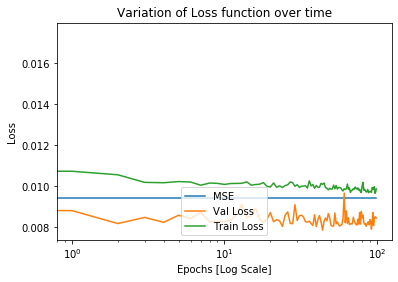

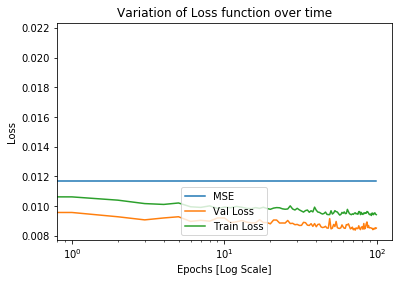

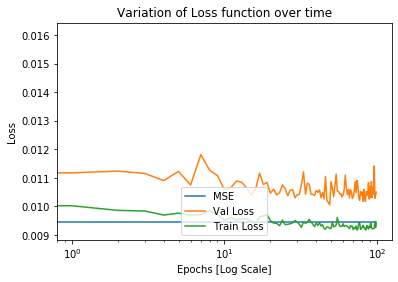

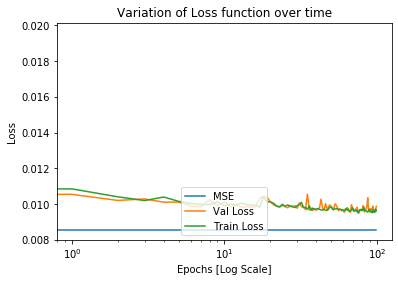

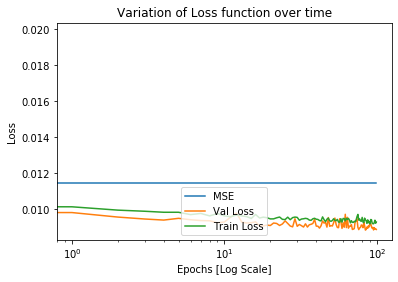

Average Time Taken: 4.5447088 seconds
Average MSE: 0.010106316178063977, Min MSE: 0.008537114011520483, Max MSE: 0.011705295453407953


In [8]:
data_size = 10000
notebook_instance_id = "xlarge"
input_dir = "s3://cloud-project-x"
output_dir = f"s3://cloud-project-x/output_{data_size}_{notebook_instance_id}"
main_function(data_size, input_dir, output_dir)